<a href="https://colab.research.google.com/github/k-washi/GoogleColab_ML/blob/master/cv_std_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets,transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
is_cuda=False
if torch.cuda.is_available():
    is_cuda = True

In [0]:
transformation = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = datasets.MNIST('data/',train=True,transform=transformation,download=True)
test_dataset = datasets.MNIST('data/',train=False,transform=transformation,download=True)

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=32,shuffle=True)

In [28]:
print(train_loader.batch_size)

32


In [0]:
def plot_img(image):
    image = image.numpy()[0]
    mean = 0.1307
    std = 0.3081
    image = ((mean * image) + std)
    plt.imshow(image,cmap='gray')

torch.Size([1, 28, 28])


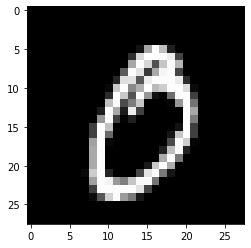

In [30]:
sample_data = next(iter(train_loader))
print(sample_data[0][2].size())
plot_img(sample_data[0][2])

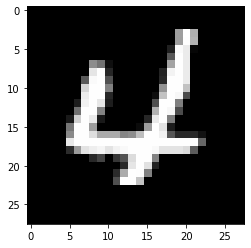

In [31]:
plot_img(sample_data[0][1])

In [0]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2)) #32x1x28x28
        x = x.view(-1, 320) #flatten
        x = F.relu(self.fc1(x))
        #x = F.dropout(x,p=0.1, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)

In [0]:
model = Net()
if is_cuda:
    model.cuda()

In [0]:
optimizer = optim.SGD(model.parameters(),lr=0.01)

In [0]:
data , target = next(iter(train_loader))

In [0]:
output = model(Variable(data.cuda()))

In [37]:
output.size()

torch.Size([32, 10])

In [38]:
target.size()

torch.Size([32])

PyTorchのクロスエントロピー周りは少し注意が必要。functional.cross_entropyはnll_lossとsoftmaxを組合せた関数。モデル側にsoftmaxを入れて，損失関数には単純に負のlog尤度関数(negative-log-likelihood)を使う場合にはnll_lossを使う。

In [0]:
def fit(epoch,model,data_loader,phase='training',volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0.0
    for batch_idx , (data,target) in enumerate(data_loader):
        if is_cuda:
            data,target = data.cuda(),target.cuda()
        #data , target = data, target#Variable(data,volatile),Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output,target)
        
        running_loss += F.nll_loss(output,target,size_average=False).data
        preds = output.data.max(dim=1,keepdim=True)[1]
        #print(output.data.max(dim=1,keepdim=True)[1])
        
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()
    
    loss = running_loss/len(data_loader.dataset)
    accuracy = 100. * running_correct/len(data_loader.dataset)
    
    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss,accuracy

maxの使い方
+ dimを省略するとinputの中で一番大きい値を返す。
+ dim=1を指定すると行方向で1番大きい値を返す。
+ dim=0を指定すると列方向で1番大きい値を返す。
```
 0.6857  0.1098  0.4687  0.7822
 0.4170  0.2476  0.1339  0.5563
 0.9425  0.8433  0.1335  0.3169
```
y.max(1) returns two tensors…

# 1. the max value in each row of y
```
 0.7822
 0.5563
 0.9425
```
# 2. the column index at which the max value is found.
```
 3
 3
 0
```

In [44]:
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,10):
    epoch_loss, epoch_accuracy = fit(epoch,model,train_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,model,test_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


training loss is 0.078 and training accuracy is 58576.0/60000     97.63
validation loss is 0.038 and validation accuracy is 9870.0/10000      98.7
training loss is 0.074 and training accuracy is 58651.0/60000     97.75
validation loss is 0.037 and validation accuracy is 9884.0/10000     98.84
training loss is  0.07 and training accuracy is 58741.0/60000      97.9
validation loss is 0.037 and validation accuracy is 9876.0/10000     98.76
training loss is  0.07 and training accuracy is 58735.0/60000     97.89
validation loss is 0.035 and validation accuracy is 9878.0/10000     98.78
training loss is 0.068 and training accuracy is 58798.0/60000      98.0
validation loss is 0.032 and validation accuracy is 9889.0/10000     98.89
training loss is 0.063 and training accuracy is 58847.0/60000     98.08
validation loss is 0.033 and validation accuracy is 9890.0/10000      98.9
training loss is 0.061 and training accuracy is 58918.0/60000      98.2
validation loss is  0.03 and validation accura

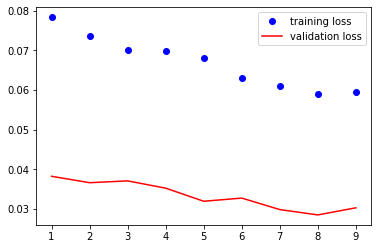

In [45]:
plt.plot(range(1,len(train_losses)+1),train_losses,'bo',label = 'training loss')
plt.plot(range(1,len(val_losses)+1),val_losses,'r',label = 'validation loss')
plt.legend()

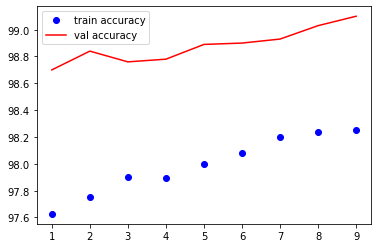

In [46]:
plt.plot(range(1,len(train_accuracy)+1),train_accuracy,'bo',label = 'train accuracy')
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,'r',label = 'val accuracy')
plt.legend()